In [1]:
import os
import sys
import warnings

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


# Plotting
import matplotlib.pyplot as plt
import scienceplots # Need to import science plots
plt.style.use(['science'])
plt.rcParams['text.usetex'] = False # This is in case there are any issues with tex, turn to true if you have it and want nice plots with tex

# Essentials
import numpy as np
import pandas as pd
from gwpy.timeseries import TimeSeries
# import bilby


In [2]:
from glitchstream.glitch_population import GlitchPopulation
from glitchstream.glitch_generator import GlitchGenerator
from glitchstream.glitch_stream import GlitchFrameGenerator    

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
# glitch population takes random gpss from gravity spy correpsonding to glitches with
# user defined properties (labels, original snr, original interferometer...)
glitch_population = GlitchPopulation(glitch_labels=["Blip",
                                                    "Tomte",
                                                    "Koi_Fish",
                                                    "Scattered_Light",
                                                    "Low_Frequency_Bursts"])

# glitch_generator takes a glitch population as argument and then extract the correpsonfing glitch   
# with the "get_random_glitch" method
glitch_generator  = GlitchGenerator(glitch_population=glitch_population)


# glitch frame generator injects glitches from glitch_generator in a arbitrary psd or returns whitened strain

# ifo = bilby.gw.detector.InterferometerList(["ET"])[0]
glitch_stream = GlitchFrameGenerator(glitch_generator = glitch_generator,
                                    #  detector=ifo,
                                     duration = 10, # frame duration
                                     glitch_rate = 1/4, # rate of glitches per second.  
                                     fmin = 15) # fmin for the glitch. withy LIGO psds its better to not go below this



reading dataset H1 O3a... 
reading dataset H1 O3b... 
reading dataset L1 O3a... 
reading dataset L1 O3b... 


/home/lucanegri/anaconda3/envs/caml_gw3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


succesfully loaded Deepextractor model from /home/lucanegri/Documents/CAML/2025/ML_2025_2026/Projects/GW3/glitchstream/glitchstream/deepextractor/checkpoints/DeepExtractor_257/checkpoint_best_real_noise_base.pth.tar 
succesfully loaded scaler from /home/lucanegri/Documents/CAML/2025/ML_2025_2026/Projects/GW3/glitchstream/glitchstream/deepextractor/checkpoints/scaler.pkl 


/home/lucanegri/anaconda3/envs/caml_gw3/lib/python3.11/site-packages/gwpy/types/series.py:991: UserWarning: TimeSeries.crop given end larger than current end, crop will begin when the Series actually ends.
  warn(


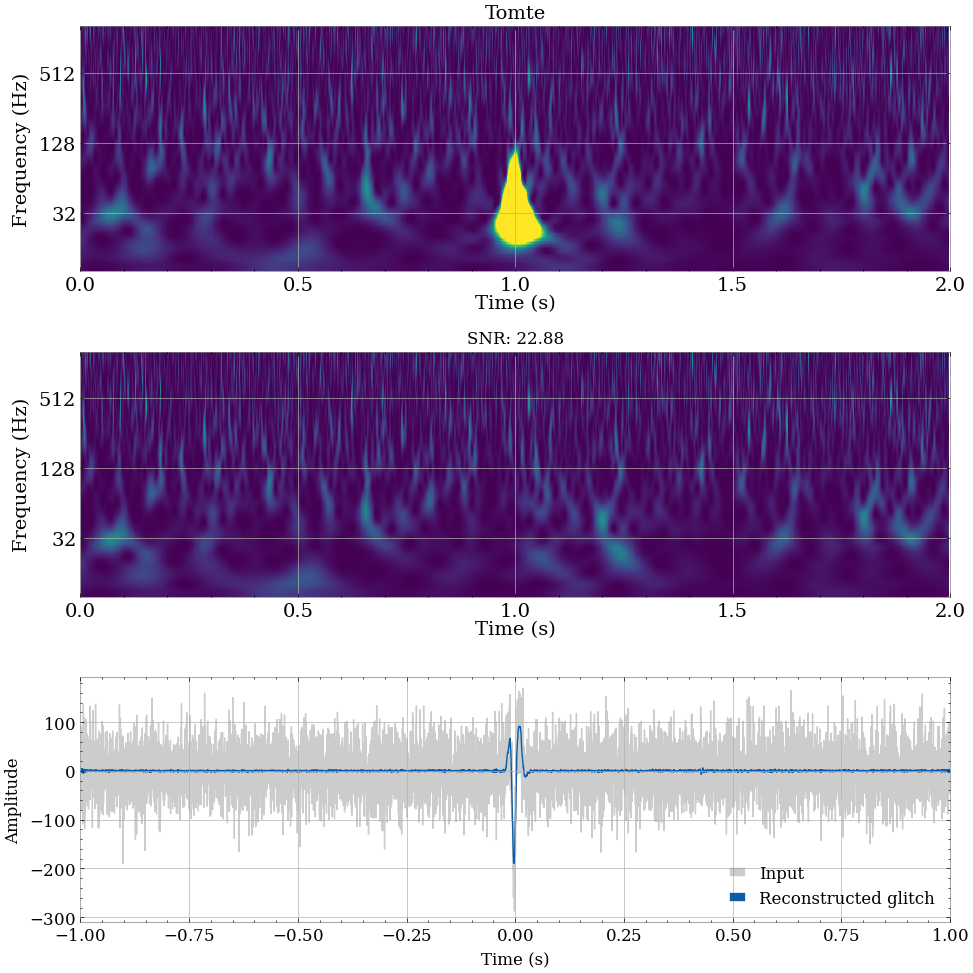

In [4]:
# generate a few glitches to test if everything is working
# if no GPU is present it will take ~ 20 seconds per glitch 
_ = glitch_generator.get_random_glitch(seed = 11,plot_glitches = True)



In [ ]:
# To generate frame 
frame_1,to_previous_frame,to_future_frame,metadata_1 = glitch_stream.generate_frame(seed = 910,
                                                                                    plot_glitches=False,
                                                                                    return_whitened = True,
                                                                                    t0 = 0,
                                                                                    verbose = 1)



N. 3 glitches to be injected in frame 


 67%|██████▋   | 2/3 [00:33<00:16, 16.91s/it]

Backgorund not poperly removed, skipping


/home/luca.negri/.conda/envs/gwsim/lib/python3.11/site-packages/gwpy/types/series.py:991: UserWarning: TimeSeries.crop given end larger than current end, crop will begin when the Series actually ends.
  warn(
100%|██████████| 3/3 [01:06<00:00, 22.19s/it]


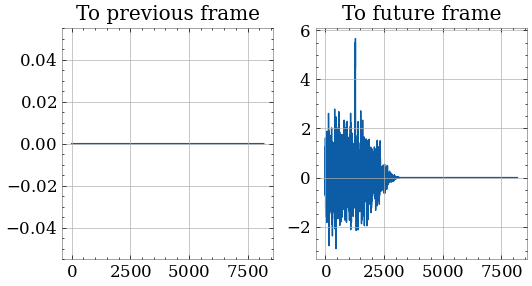

In [ ]:
plt.figure(figsize = [6,3])
plt.subplot(121)
plt.title("To previous frame")
plt.plot(to_previous_frame)
plt.subplot(122)
plt.title("To future frame")
plt.plot(to_future_frame)
plt.show()


In [ ]:
# color frame with ET PSD
frame_1_coloured = glitch_stream.color_glitch_frame(frame_1)

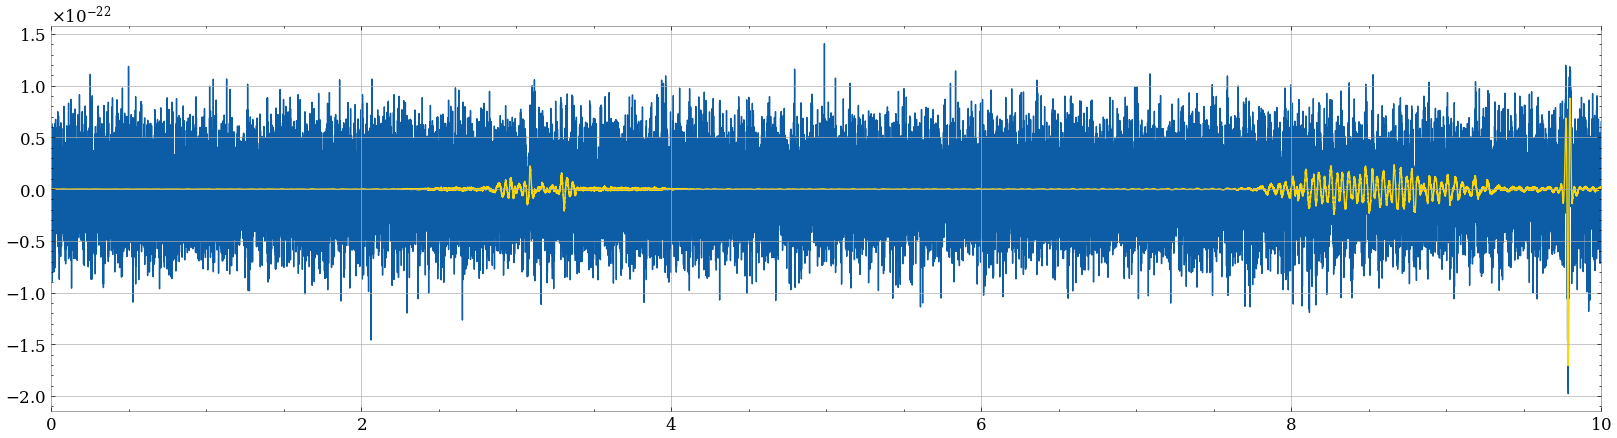

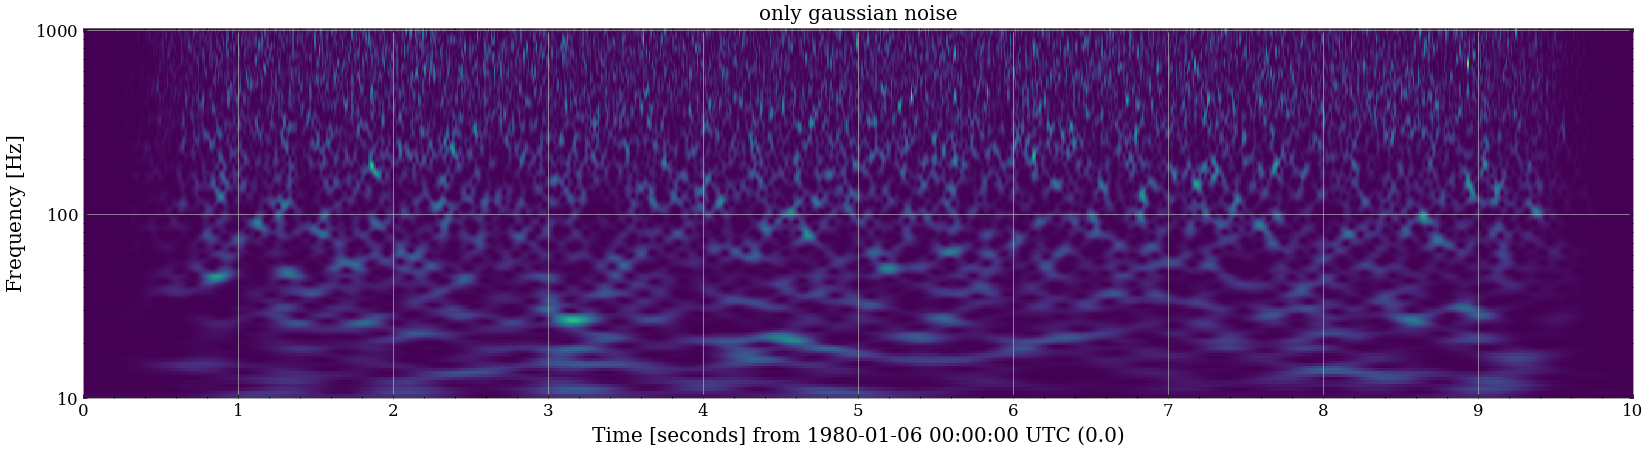

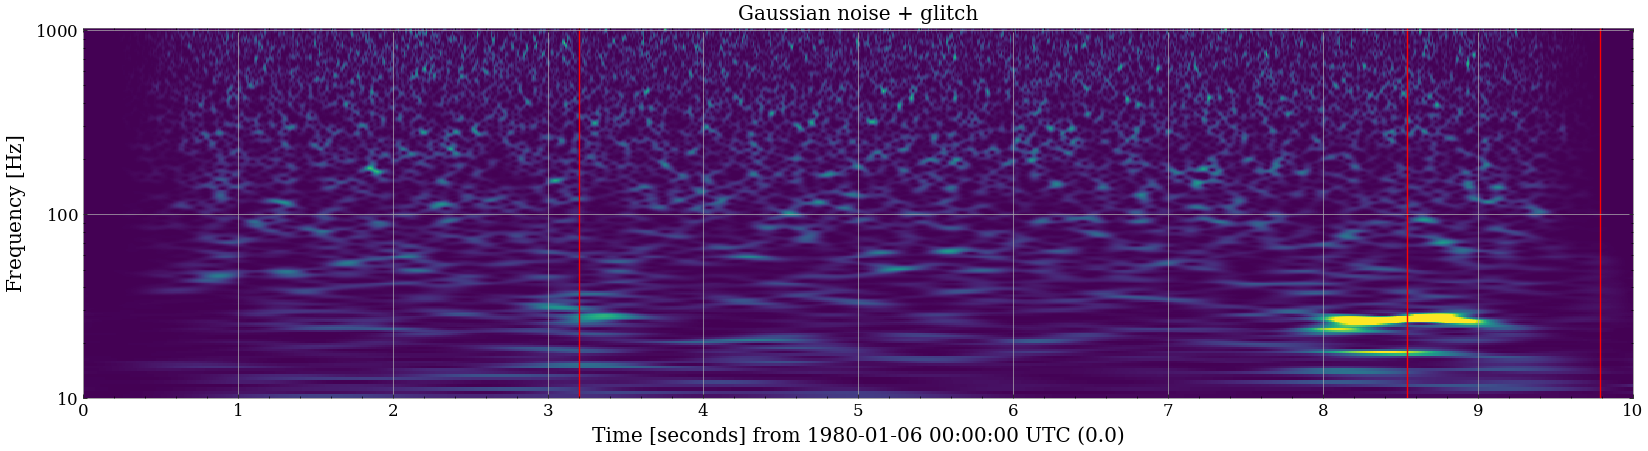

In [ ]:
# plot results onb top of gaussian noise
ifo.set_strain_data_from_power_spectral_density(
    sampling_frequency=glitch_stream.sampling_frequency,
    duration=glitch_stream.duration,
    start_time=0, # type: ignore
)

base_noise = TimeSeries(ifo.time_domain_strain,dt = 1/glitch_stream.sampling_frequency,t0 = 0)
glitched_timeseries = base_noise + np.array(frame_1_coloured)

glitch_times = np.array(metadata_1.frame_time)



plt.figure(figsize = [20,5])
# white_noise_and_glitch = np.random.normal(0,50,size = len(glitch_frame))  +glitch_frame
# plt.plot(white_noise_and_glitch)
# plt.subplot(131)
t = np.array(glitched_timeseries.times)
plt.plot(t,glitched_timeseries)
plt.plot(t,frame_1_coloured,color = "gold")
plt.xlim(0,glitch_stream.duration)
plt.show()

# plt.subplot(132)
q_scan = base_noise.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                whiten = True
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [20,5],title = "only gaussian noise")

plt.yscale("log")

q_scan = glitched_timeseries.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                whiten = True,
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [20,5],title = "Gaussian noise + glitch")
for glitch_time in glitch_times:
    plt.axvline(glitch_time,color = "red")
plt.yscale("log")
plt.show()

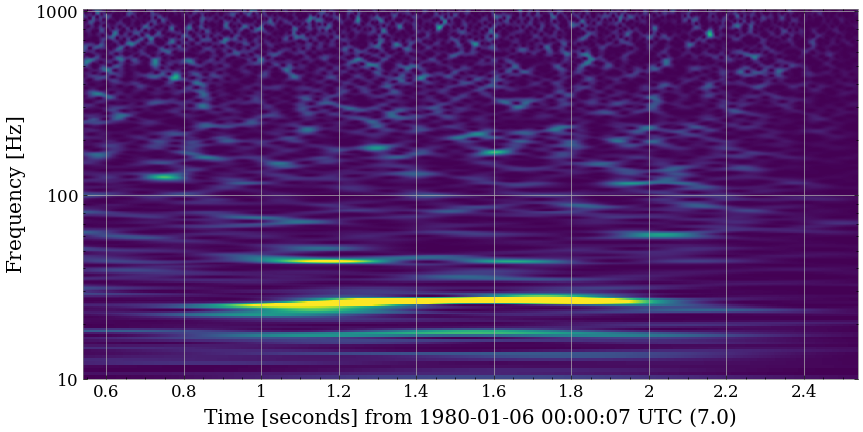

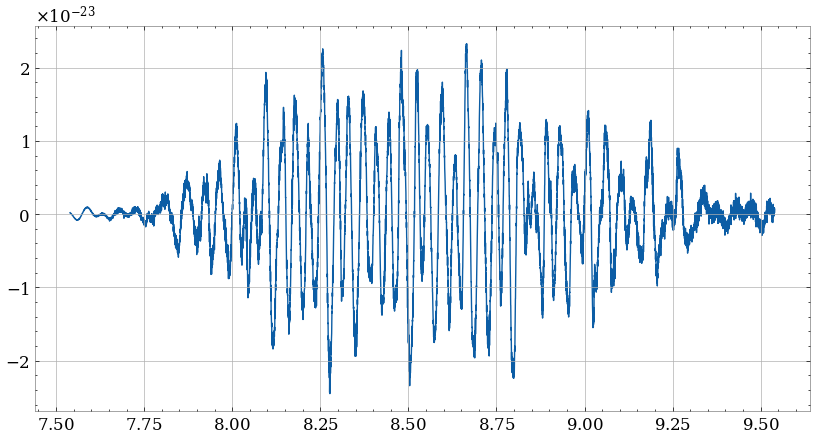

In [ ]:
# plot single glitch to double check everything's good
idx = 1
t_g = glitch_times[idx]

q_scan = glitched_timeseries.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                outseg = (t_g-1,t_g+1),
                                whiten = True
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [10,5])


plt.yscale("log")
plt.show()
plt.figure(figsize = [10,5])
plt.plot(frame_1_coloured.crop(t_g-1,t_g+1))

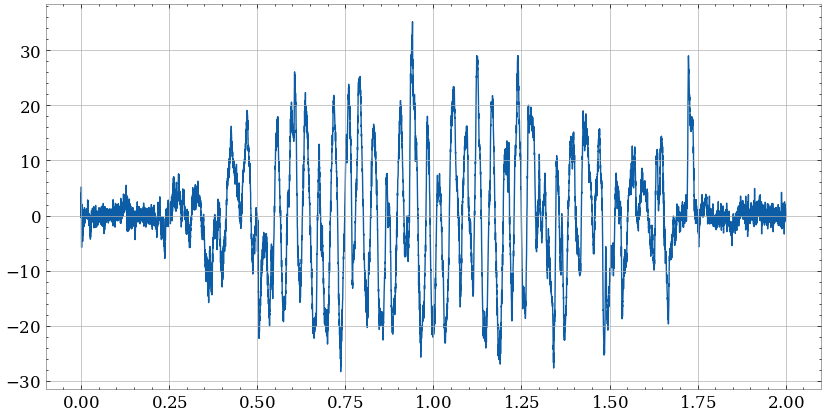

In [ ]:
# re-extract original glitch just to double check
gps_time,ifo_name = metadata_1.iloc[idx][["event_time","ifo"]]
psd,glitch_timeseries,glitch = glitch_generator.glitch_downloader.get_glitch(gps_time,ifo_name)

g_hat,n_hat = glitch_generator.deepextractor(glitch)
g_hat_timeseries = TimeSeries(g_hat,dt = 1/4096)
plt.figure(figsize = [10,5])

plt.plot(g_hat_timeseries)

# second frame

In [ ]:
# handle phasing from previous frame
len_phasing = len(to_future_frame)
from_previous_frame  = to_future_frame
frame_2,to_previous_frame,to_future_frame,metadata_2 = glitch_stream.generate_frame(seed = 905,plot_glitches=False,return_whitened = True)
frame_2[:len_phasing] += from_previous_frame
frame_2_coloured = glitch_stream.color_glitch_frame(frame_2)


In [ ]:
ifo

'L1'

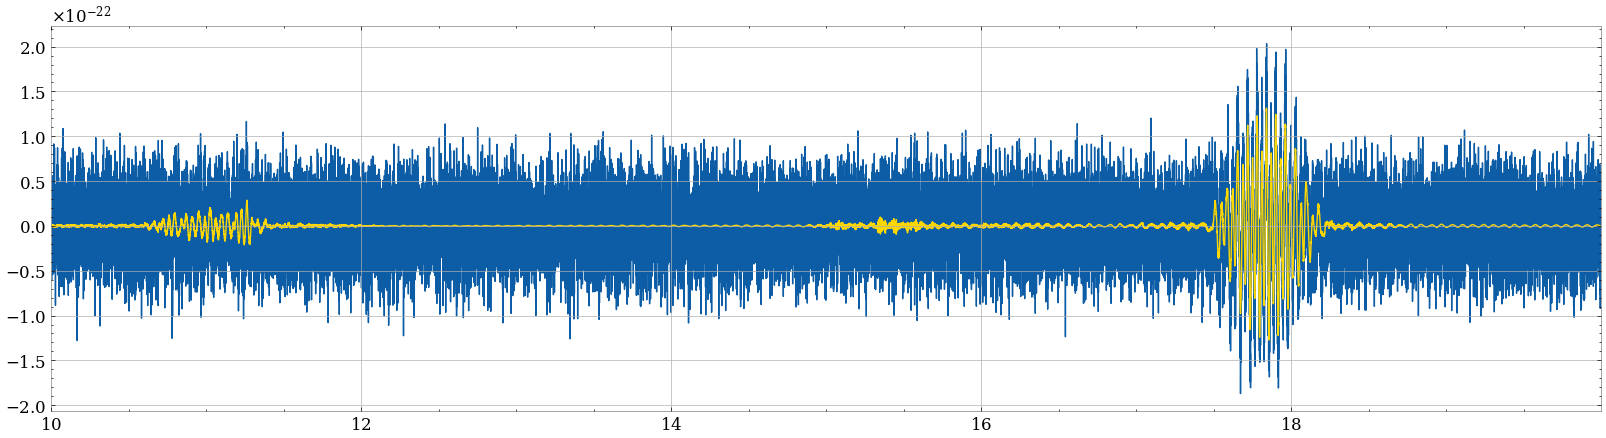

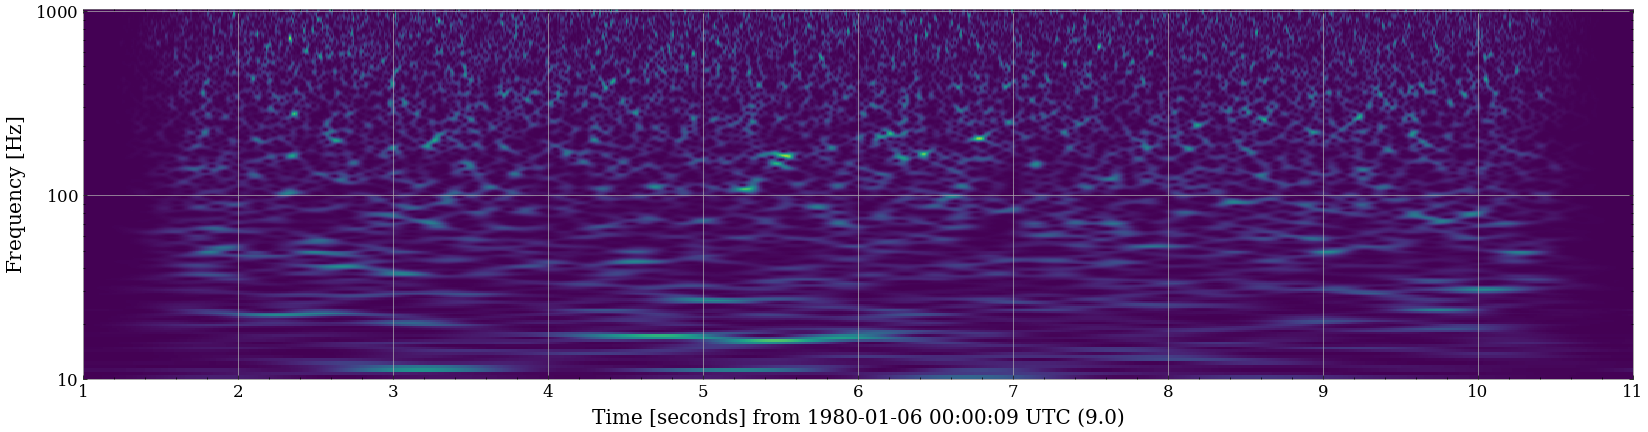

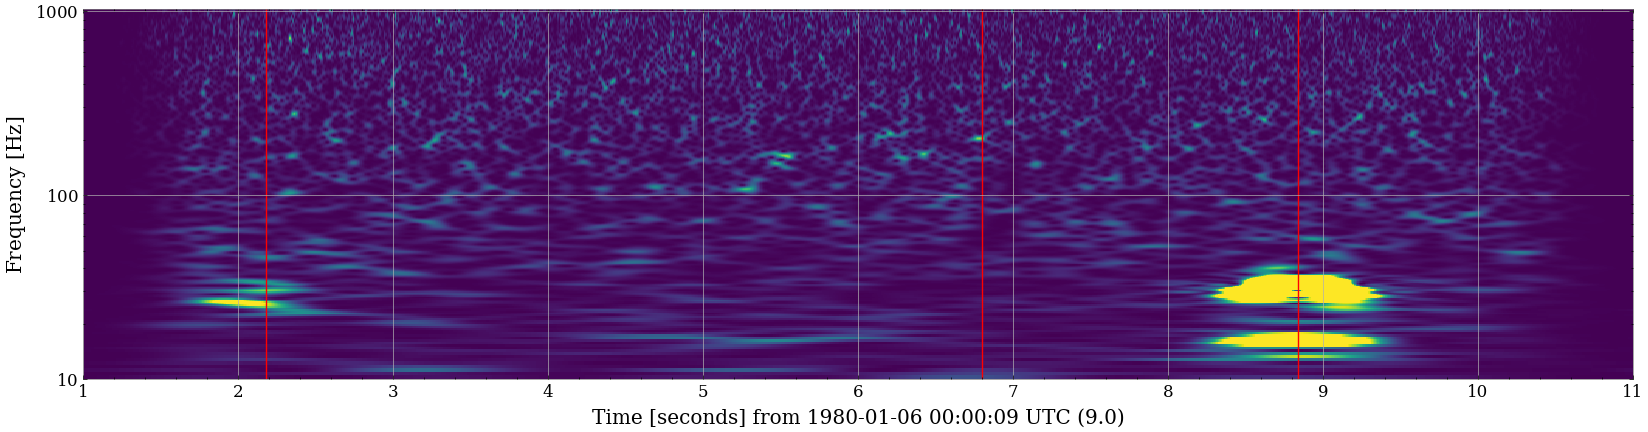

In [ ]:
ifo = bilby.gw.detector.InterferometerList(["ET"])[0]
ifo.set_strain_data_from_power_spectral_density(
    sampling_frequency=glitch_stream.sampling_frequency,
    duration=glitch_stream.duration,
    start_time=0, # type: ignore
)

base_noise = TimeSeries(ifo.time_domain_strain,dt = 1/glitch_stream.sampling_frequency,t0 = frame_2.t0)
glitched_timeseries = base_noise +np.array(frame_2_coloured)

glitch_times = np.array(metadata_2.frame_time)



plt.figure(figsize = [20,5])

t = np.array(glitched_timeseries.times)
plt.plot(t,glitched_timeseries)
plt.plot(t,frame_2_coloured,color = "gold")
plt.xlim(t[0],t[-1])
plt.show()

q_scan = base_noise.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                whiten = True
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [20,5])

plt.yscale("log")

q_scan = glitched_timeseries.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                whiten = True,
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [20,5])
for glitch_time in glitch_times:
    plt.axvline(glitch_time,color = "red")
plt.yscale("log")
plt.show()

#  cobine multiple frames

In [ ]:
metadata = pd.concat([metadata_1,metadata_2])

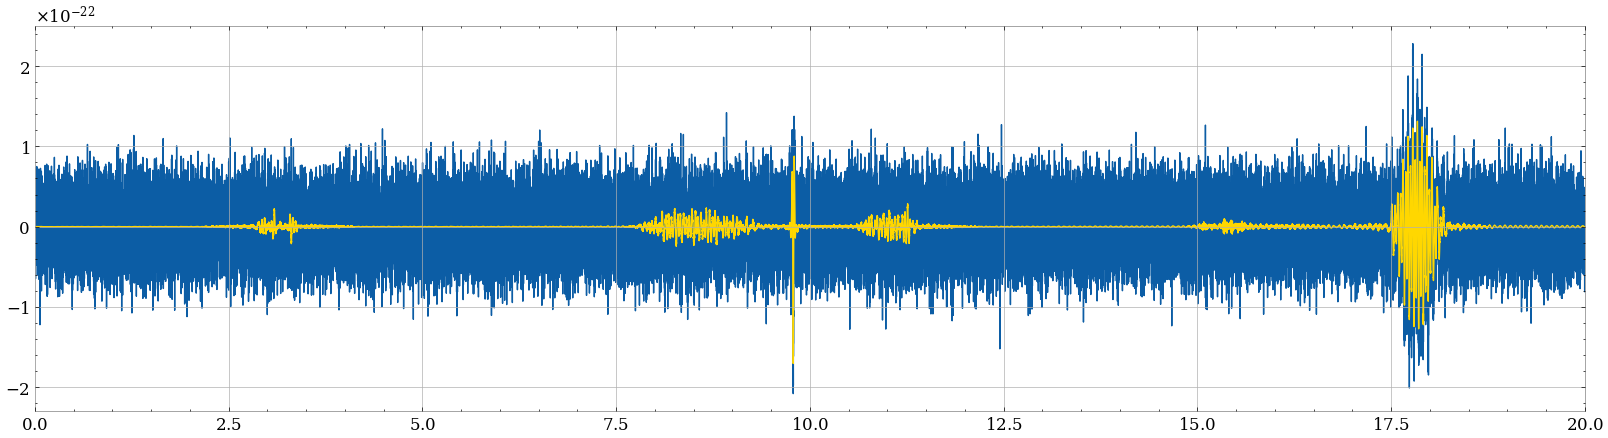

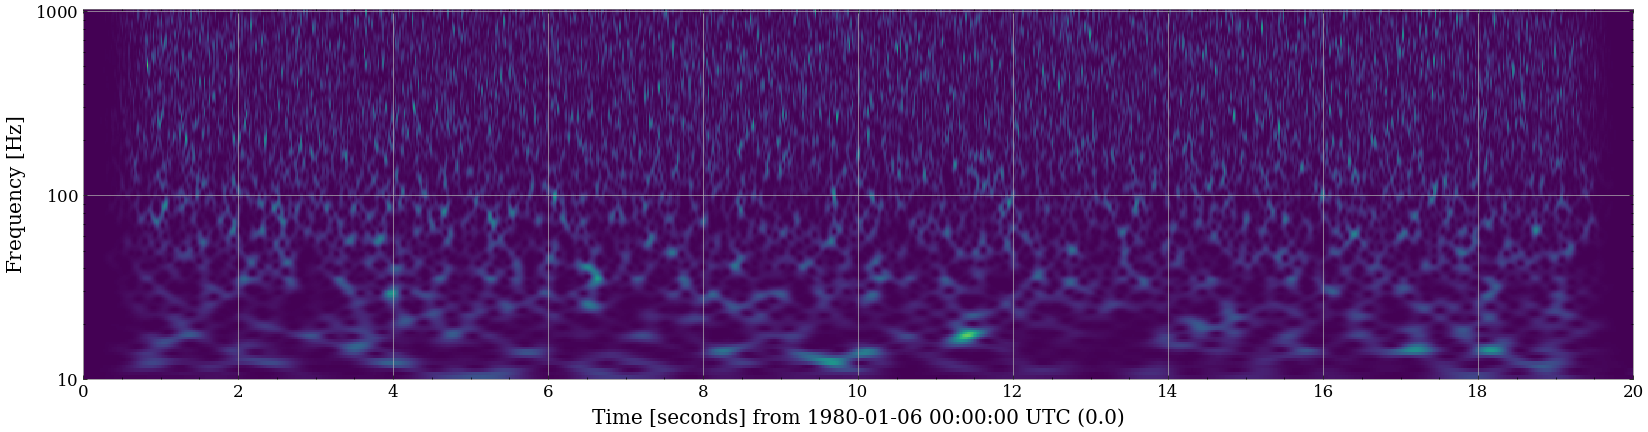

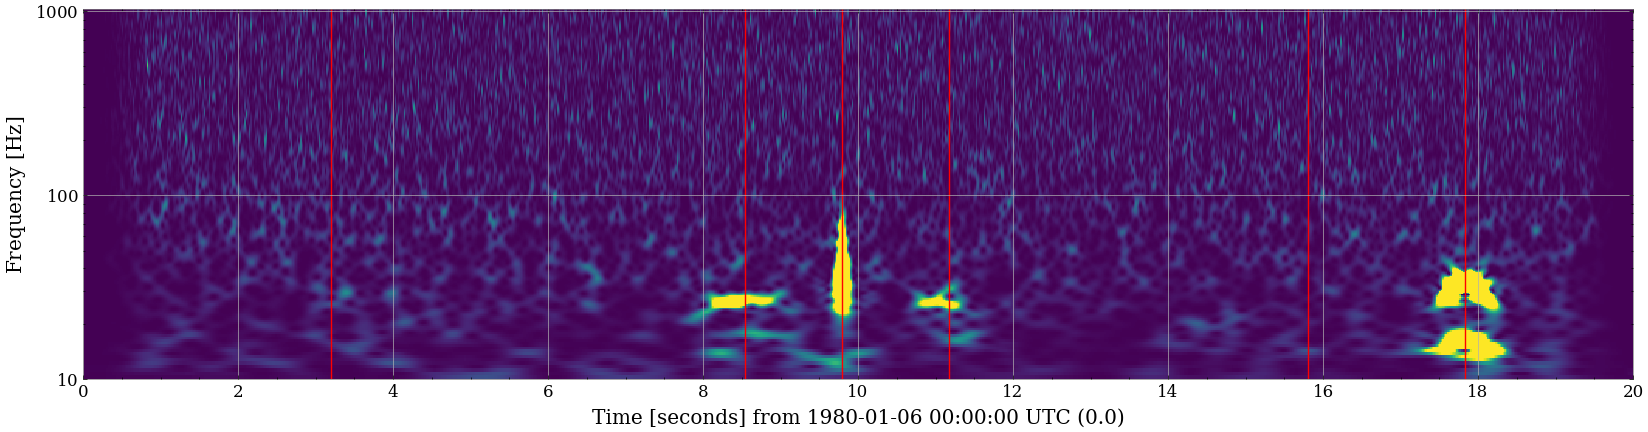

In [ ]:
# check if frames collate
frame_tot = np.concatenate([frame_1_coloured,frame_2_coloured])

ifo = bilby.gw.detector.InterferometerList(["ET"])[0]
ifo.set_strain_data_from_power_spectral_density(
    sampling_frequency=glitch_stream.sampling_frequency,
    duration=glitch_stream.duration*2,
    start_time=0, # type: ignore
)

base_noise = TimeSeries(ifo.time_domain_strain,dt = 1/glitch_stream.sampling_frequency,t0 = 0)
glitched_timeseries = base_noise +np.array(frame_tot)

glitch_times = np.array(metadata.frame_time)



plt.figure(figsize = [20,5])
t = np.array(glitched_timeseries.times)
plt.plot(t,glitched_timeseries)
plt.plot(t,frame_tot,color = "gold")
plt.xlim(0,glitch_stream.duration*2)
plt.show()

q_scan = base_noise.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                whiten = True
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [20,5])

plt.yscale("log")

q_scan = glitched_timeseries.q_transform(qrange = (8,64),
                                frange = (10,1024),
                                whiten = True,
                                )
q_scan.plot(vmin = 0,vmax = 25,figsize = [20,5])
for glitch_time in glitch_times:
    plt.axvline(glitch_time,color = "red")
plt.yscale("log")
plt.show()

(9.9, 10.1)

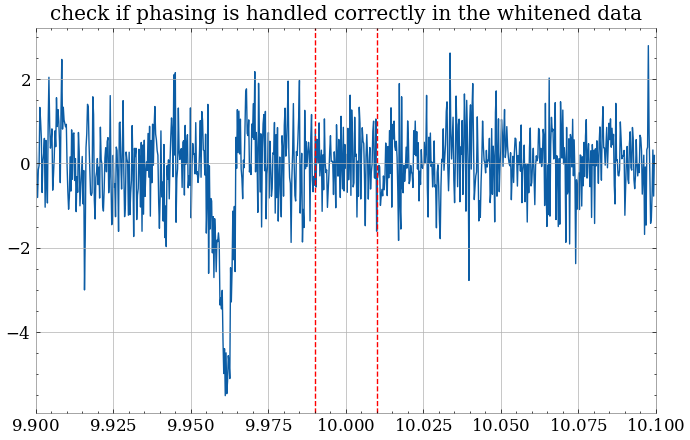

In [ ]:
plt.figure(figsize = [8,5])
frame_tot = np.concatenate([frame_1,frame_2])

plt.title("check if phasing is handled correctly in the whitened data")
plt.plot(frame_tot.crop(9.9,10.1))
plt.axvline(9.99 ,color = "red",linestyle = "dashed")
plt.axvline(10.01,color = "red",linestyle = "dashed")

plt.xlim(9.9,10.1)